In [1]:
# Third Party Imports
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from exphelperfunctions import abbrv_num
from exphelperfunctions import objectToFile
from exphelperfunctions import objectFromFile
from exphelperfunctions import add_value_labels

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load original datasets

In [3]:
#Open CICIDS2019 train
columns = ['Flow Duration','Protocol','Total Length of Fwd Packets','Total Length of Bwd Packets', \
           'Fwd Packet Length Mean','Bwd Packet Length Mean','Total Fwd Packets','Total Backward Packets', \
           'Fwd IAT Mean','Bwd IAT Mean','Fwd IAT Std','Label', 'Timestamp', 'Flow Packets/s']

ngramcolumns = ['Flow Duration', 'Timestamp','Source IP','Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min', 'Label', 'Timestamp']

dtypes = {'Flow Duration':np.int32,'Protocol': np.int8,'Total Length of Fwd Packets':np.int32,'Total Length of Bwd Packets':np.int32, \
          'Fwd Packet Length Mean':np.float32,'Bwd Packet Length Mean':np.float32,'Total Fwd Packets':np.int32, \
          'Total Backward Packets':np.int16,'Fwd IAT Mean':np.float32,'Bwd IAT Mean':np.float32, 'Fwd IAT Std': np.float32, \
          'Fwd Packet Length Max': np.int16, 'Fwd Packet Length Min': np.int16, 'Bwd Packet Length Max': np.int32, \
          'Bwd Packet Length Min': np.int16, 'Flow IAT Mean': np.float32, 'Flow IAT Std': np.float32, \
          'Flow IAT Max': np.int32, 'Flow IAT Min': np.int32, 'Label':object}

dirpath_train = "/mnt/h/CICIDS/DDoS2019/train/"

#Remove below attacks from train set as test set does not have them
excludelabels = ['DrDoS_NTP', 'DrDoS_DNS', 'DrDoS_SNMP', 'DrDoS_SSDP', 'TFTP']
filepaths_train = [dirpath_train+f for f in os.listdir(dirpath_train) \
                   if (f.endswith('.csv') and  not any(label in f for label in excludelabels))]


print("Importing training data: starting with " + filepaths_train[0])
df_train = pd.read_csv(filepaths_train[0] ,sep=',',header=0, usecols=columns, dtype= dtypes, skipinitialspace=True)
for filename in filepaths_train[1:]:
    print("Concatenating: " + filename)
    df_train = pd.concat([df_train,pd.read_csv(filename, sep=',',header=0, usecols=columns, dtype= dtypes, skipinitialspace=True)],ignore_index=True)
    
df_train.sort_values(by='Timestamp', inplace=True)

Importing training data: starting with /mnt/h/CICIDS/DDoS2019/train/DrDoS_LDAP.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/train/DrDoS_MSSQL.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/train/DrDoS_NetBIOS.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/train/DrDoS_UDP.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/train/Syn.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/train/UDPLag.csv


In [4]:
#Open CICIDS2019 test
dirpath_test = "/mnt/h/CICIDS/DDoS2019/test/"
ngramcolumns = ['Flow Duration', 'Timestamp','Source IP','Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min', 'Label']

dtypes = {'Flow Duration':np.int32,'Protocol': np.int8,'Total Length of Fwd Packets':np.int32,'Total Length of Bwd Packets':np.int32,'Fwd Packet Length Mean':np.float32,'Bwd Packet Length Mean':np.float32,'Total Fwd Packets':np.int32,'Total Backward Packets':np.int16,'Fwd IAT Mean':np.float32,'Bwd IAT Mean':np.float32, 'Fwd IAT Std': np.float32,'Label':object}

#Remove below attack from test set as train set does not have it
excludelabel = 'Portmap'
filepaths_test = [dirpath_test+f for f in os.listdir(dirpath_test) if (f.endswith('.csv') and not excludelabel in f)]

print("Importing testing data: starting with " + filepaths_test[0])
df_test = pd.read_csv(filepaths_test[0] ,sep=',',header=0, usecols=columns, dtype= dtypes, skipinitialspace=True)
for filename in filepaths_test[1:]:
    print("Concatenating: " + filename)
    df_test = pd.concat([df_test,pd.read_csv(filename, sep=',',header=0, usecols=columns, dtype= dtypes, skipinitialspace=True)],ignore_index=True)
    
df_test.sort_values(by='Timestamp', inplace=True)

Importing testing data: starting with /mnt/h/CICIDS/DDoS2019/test/LDAP.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/test/MSSQL.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/test/NetBIOS.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/test/Syn.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/test/UDP.csv
Concatenating: /mnt/h/CICIDS/DDoS2019/test/UDPLag.csv


In [5]:
#Drop rows with infinity values of packet/s feature
with pd.option_context('mode.use_inf_as_na', True):
    df_train.dropna(subset=['Flow Packets/s'], how='all', inplace=True)
    df_test.dropna(subset=['Flow Packets/s'], how='all', inplace=True)
    
#Drop WebDDoS attack label as test set does not have it but its also mixed in other files
df_train.drop(index=df_train[df_train['Label'] == 'WebDDoS'].index, inplace=True)

# Add binary label and fix test label

In [20]:
df_train['BinLabel'] = np.where(df_train['Label'] == 'BENIGN', 'Benign','Malicious')
print(df_train['BinLabel'].value_counts())
print(df_train['Label'].value_counts())

Malicious    17948693
Benign          53092
Name: BinLabel, dtype: int64
MSSQL      5212109
Syn        4033589
UDP        3645100
NetBIOS    3260427
LDAP       1795595
BENIGN       53092
UDP-lag       1873
Name: Label, dtype: int64


In [21]:
df_test['BinLabel'] = np.where(df_test['Label'] == 'BENIGN', 'Benign','Malicious')
print(df_test['BinLabel'].value_counts())
print(df_test['Label'].value_counts())

Malicious    8570126
Benign         32455
Name: BinLabel, dtype: int64
DrDoS_MSSQL      2458902
DrDoS_NetBIOS    2252286
DrDoS_UDP        1798872
DrDoS_LDAP       1241093
Syn               642981
UDP-lag           175992
BENIGN             32455
Name: Label, dtype: int64


# Data composition (before removing NaNs)

## Training data
Benign: 11,579 instances (0.07%)

Malicious: 15,879,535 instances (99.93%)

## Testing data
Benign: 52,231 instances (0.26%)

Malicious: 20,120,600 instances (99.74%)

# One hot encoding

In [8]:
# One hot encoding for protocol
ohe_df = pd.get_dummies(df_train['Protocol'], prefix="proto")
df_train = df_train.join(ohe_df)

ohe_df = pd.get_dummies(df_test['Protocol'], prefix="proto")
df_test = df_test.join(ohe_df)

# Combine datasets and select features

In [9]:
#Get input columns and corresponding label vector
#Use duration, protocol, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow
#features = df_train.drop(['id','proto','service','state','attack_cat','label'],axis=1)
features = ['Flow Duration','proto_0','proto_6','proto_17','Total Length of Fwd Packets','Total Length of Bwd Packets','Fwd Packet Length Mean','Bwd Packet Length Mean','Total Fwd Packets','Total Backward Packets','Fwd IAT Mean','Bwd IAT Mean']

#Switch train and test set from their site for better classification scores due to sample size during training
label = 'BinLabel'
y_train = df_test[label]
y_test = df_train[label]
df_temp = df_train.copy()
df_train = df_test[features].copy()
df_test = df_temp[features]
df_temp = np.nan

# Random Forest implementation

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
cfs = []
preds = []
for i in range(5):
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5,verbose=10)
    rf_clf.fit(df_train,y_train)
    y_pred = rf_clf.predict(df_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100building tree 9 of 100



[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   22.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   42.0s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.1min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.5min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.1min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min


building tree 46 of 100
building tree 47 of 100building tree 48 of 100

building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  3.3min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  3.9min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  4.7min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  5.5min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    7.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:   15.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   26.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   25.6s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   44.0s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.1min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.6min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.2min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  3.3min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100building tree 60 of 100

building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.0min


building tree 68 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  4.9min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  5.7min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   22.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   26.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100

building tree 5 of 100


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   21.6s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   43.2s


building tree 15 of 100building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.1min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.6min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.0min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100building tree 40 of 100

building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  3.2min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  3.9min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  4.8min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  5.5min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:   16.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   19.7s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   27.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   30.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   23.7s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   42.1s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.1min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.6min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.1min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  3.3min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.0min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100building tree 81 of 100



[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  4.8min


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  5.6min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:   15.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   22.6s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   26.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   21.2s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   43.2s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.0min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.5min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.1min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  3.2min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.0min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  4.6min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  5.4min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   25.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   28.5s finished


In [11]:
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
objectToFile(preds, "ddos2019_preds_reduced_normal"+label)

[array([[   11352,      105],
       [ 1663578, 13641278]]), array([[   11417,       40],
       [ 1636411, 13668445]]), array([[   11400,       57],
       [ 1645465, 13659391]]), array([[   11375,       82],
       [ 1645483, 13659373]]), array([[   11379,       78],
       [ 1645465, 13659391]])]
(5, 2, 2)
[[1.13846000e+04 7.24000000e+01]
 [1.64728040e+06 1.36575756e+07]]
[[  22.24050359   22.24050359]
 [8872.17699553 8872.17699553]]


### Or preload results from previous run

In [3]:
#Load object from file
from sklearn.metrics import confusion_matrix
label='BinLabel'
preds_mem = objectFromFile("ddos2019_preds_reduced_normal"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

### Visualize results

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.99
paper1_rec = 0.99
paper1_spec = 0.99
paper2_acc = 0.9993
paper2_rec = 0.999
paper2_spec = 0.999
#tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
#print(tn,fp,fn,tp)

#acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
#rec_score  = tp / (tp+fn)
#spec_score = tn / (tn+fp)
acc_scores = [0.962]
rec_score = 0.962
spec_score = 0.972
print(np.mean(acc_scores), "\n")
print(rec_score, "\n")
print(spec_score)

0.962 

0.962 

0.972


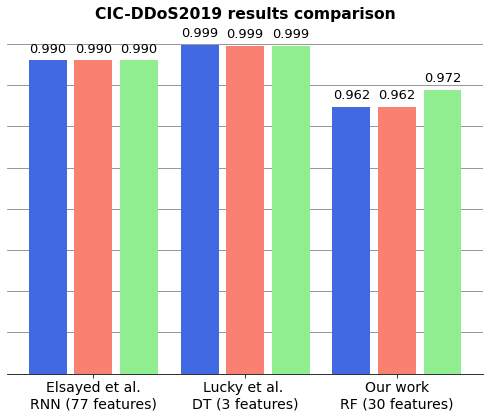

In [6]:
import matplotlib.patches as mpatches
#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['Elsayed et al.\nRNN (77 features)', 'Lucky et al. \nDT (3 features)', 'Our work\nRF (30 features)']
x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [paper1_acc,paper1_rec,paper1_spec,paper2_acc,paper2_rec,paper2_spec,np.mean(acc_scores),rec_score,spec_score]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0], height=scores[1], width=width, color=clr_rec)
plt.bar(x[0]+pad_width, height=scores[2], width=width, color=clr_spec)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width, height=scores[3], width=width, color=clr_acc)
plt.bar(x[1], height=scores[4], width=width, color=clr_rec)
plt.bar(x[1]+pad_width, height=scores[5], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[6], width=width, color=clr_acc)
plt.bar(x[2], height=scores[7], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[8], width=width, color=clr_spec)

#Hide the left, right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
#plt.ylabel('Metric score')
plt.yticks()
ax.set_yticklabels([])
#ax.get_yaxis().set_visible(False)
plt.xticks(size='14')
plt.ylim([0.8, 1])
plt.title("CIC-DDoS2019 results comparison", fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y', color='grey')
fig.tight_layout()
plt.savefig('ddos2019_binaryclass_reduced_bars.png',bbox_inches='tight')
plt.show()

In [12]:
np.set_printoptions(suppress=True)
print('mean\n', np.mean(cfs,axis=0))
print('std. dev\n', np.std(cfs,axis=0))
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

mean
 [[   11384.6       72.4]
 [ 1647280.4 13657575.6]]
std. dev
 [[  22.24050359   22.24050359]
 [8872.17699553 8872.17699553]]
std. dev %
 [[ 0.19535604 30.71892761]
 [ 0.53859543  0.06496158]]


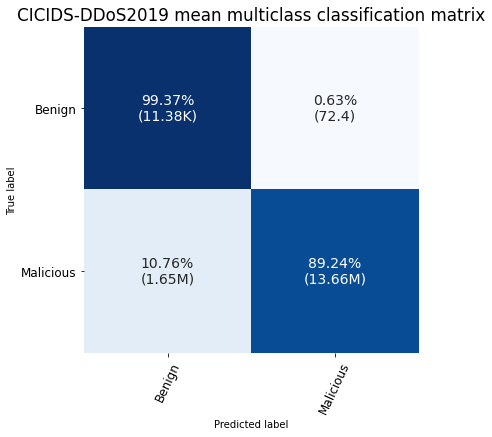

In [13]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#column_labels = sorted(y_test.unique())
#column_labels[6] = 'Benign'
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("CICIDS-DDoS2019 mean multiclass classification matrix")
plt.savefig('ddos2019_binaryclass_cf_reduced.png',bbox_inches='tight')
plt.show()

In [14]:
importance = rf_clf.feature_importances_
print(features)
print(importance)
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

['Flow Duration', 'proto_0', 'proto_6', 'proto_17', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd IAT Mean', 'Bwd IAT Mean']
[0.05142496 0.00310571 0.01284563 0.01087059 0.16057637 0.17294885
 0.1707864  0.25728134 0.08805984 0.03080252 0.02494325 0.01635454]
7
Feature: Bwd Packet Length Mean, Score: 0.25728
5
Feature: Total Length of Bwd Packets, Score: 0.17295
6
Feature: Fwd Packet Length Mean, Score: 0.17079
4
Feature: Total Length of Fwd Packets, Score: 0.16058
8
Feature: Total Fwd Packets, Score: 0.08806
0
Feature: Flow Duration, Score: 0.05142
9
Feature: Total Backward Packets, Score: 0.03080
10
Feature: Fwd IAT Mean, Score: 0.02494
11
Feature: Bwd IAT Mean, Score: 0.01635
2
Feature: proto_6, Score: 0.01285
3
Feature: proto_17, Score: 0.01087
1
Feature: proto_0, Score: 0.00311


[array([[   57521,     3410],
       [  600486, 50126860]]), array([[   57612,     3319],
       [  600329, 50127017]]), array([[   57567,     3364],
       [  600482, 50126864]]), array([[   57518,     3413],
       [  600527, 50126819]]), array([[   57455,     3476],
       [  600539, 50126807]])]

Mean:
(5, 2, 2)
[[5.75346000e+04 3.39640000e+03]
 [6.00472600e+05 5.01268734e+07]]
 
 Std. Dev.:
[[52.60646348 52.60646348]
 [75.17606002 75.17606002]]

# N-grams experiment

In [4]:
#Retain 60% of each class in df_train for lower memory usage
#Retain only 20% of the largest class
percentage = 60
for label in df_train['Label'].unique():
    label_df = df_train.loc[df_train['Label'] == label]
    if label is 'TFTP':
        cutoff = round(len(label_df)/100*20)
    else:
        cutoff = round(len(label_df)/100*percentage)
     
    indices = label_df.iloc[cutoff:].index
    print(label)
    print(len(indices))
    df_train.drop(index=indices, inplace=True)

#Clear vars to save memory
label_df = None
indices = None

DrDoS_NTP
481057
BENIGN
22745
DrDoS_DNS
2028404
DrDoS_LDAP
871972
DrDoS_MSSQL
1808997
DrDoS_NetBIOS
1637312
DrDoS_SNMP
2063948
DrDoS_SSDP
1044244
DrDoS_UDP
1253858
UDP-lag
146584
WebDDoS
176
Syn
632916
TFTP
8033032


### Show amount of source IPs with more than 'threshold' flows in train dataset

In [5]:
#Train dataset value counts per IP
threshold = 2
vc_tr = df_train['Source IP'].value_counts()
res_tr = df_train[df_train['Source IP'].isin(vc_tr[vc_tr>threshold].index)]['Source IP'].value_counts()
print(res_tr)

172.16.0.5        29994117
192.168.50.1          9855
192.168.50.7          9660
192.168.50.6          9281
192.168.50.8          8111
                    ...   
52.43.17.8               3
107.178.246.49           3
209.170.115.32           3
34.203.79.136            3
35.164.138.68            3
Name: Source IP, Length: 296, dtype: int64


## Transform df_train

In [6]:
df_train.columns
df_train.drop(['Timestamp','Label'], axis=1, inplace=True)

In [7]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'ngram_' + feature + '_mean'
    column_std = 'ngram_' + feature + '_std'
    if column_mean not in df_train.columns:
        df_train[column_mean] = np.nan
    if column_std not in df_train.columns:
        df_train[column_std] = np.nan

#List of ngram features
featurelist = df_train.filter(regex='^ngram', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, feature in enumerate(features): #Iterate over all features to be transformed
    column_mean = 'ngram_' + feature + '_mean'
    column_std = 'ngram_' + feature + '_std'
    for (srcIP, _) in res_tr.iteritems(): #Iterate over all Source IP starting with most-occurring
        sub_df = df_train[df_train['Source IP'] == srcIP]
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
        df_train.loc[:,[column_mean, column_std]] = df_train[[column_mean, column_std]].combine_first(sub_df[[column_mean, column_std]])
    df_train.drop(columns=feature)
    print('Progress: ' + str(itr+1) + '/' + str(len(features)), end='\r')
    
    

In [8]:
df_train_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_train_feather"
df_train.reset_index().to_feather(df_train_feather_path)

### Load df_train from memory and reduce memory footprint

In [3]:
#Load df_train from memory and reduce memory footprint
df_train_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_train_feather"
df_train = pd.read_feather(df_train_feather_path)

In [4]:
df_train

,index,Source IP,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,ngram_Flow Packets/s_mean,ngram_Flow Packets/s_std,ngram_Flow IAT Mean_mean,ngram_Flow IAT Mean_std,ngram_Flow IAT Std_mean,ngram_Flow IAT Std_std,ngram_Flow IAT Max_mean,ngram_Flow IAT Max_std,ngram_Flow IAT Min_mean,ngram_Flow IAT Min_std
0,15875439,172.16.0.5,2018-12-01 09:17:11.183810,5220876,12,9,1928,4290,509,0,...,2.523537,1.781701e+00,9.087319e+05,1.039182e+06,2.538956e+06,2.274210e+06,7.551302e+06,4.410475e+06,1.666667,0.57735
1,15875440,172.16.0.5,2018-12-01 09:17:11.205636,12644252,5,2,0,0,0,0,...,10527.498555,1.823109e+04,8.217331e+05,1.127674e+06,2.166503e+06,2.678909e+06,5.883026e+06,6.367569e+06,2.000000,1.00000
2,15875441,65.55.163.78,2018-12-01 09:17:12.634569,3,2,0,0,0,0,0,...,777777.777778,1.924501e+05,2.666667e+00,5.773503e-01,0.000000e+00,0.000000e+00,2.666667e+00,5.773503e-01,2.666667,0.57735
3,15875442,65.55.163.78,2018-12-01 09:17:13.458370,3,2,0,0,0,0,0,...,888888.888889,1.924501e+05,2.333333e+00,5.773503e-01,0.000000e+00,0.000000e+00,2.333333e+00,5.773503e-01,2.333333,0.57735
4,15875443,192.168.50.253,2018-12-01 09:17:13.470913,114329232,52,0,0,0,0,0,...,0.455908,2.471571e-03,2.236478e+06,1.208971e+04,4.074551e+06,2.178121e+04,9.952134e+06,3.826251e+03,1.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30037862,41637687,172.16.0.5,2018-12-01 13:48:51.421960,2998579,4,0,2064,0,516,516,...,666667.555174,1.154700e+06,6.669538e+05,5.775987e+05,1.155196e+06,1.000430e+06,2.000859e+06,1.732796e+06,1.000000,0.00000
30037863,41637688,172.16.0.5,2018-12-01 13:48:51.421962,1,2,0,1032,0,516,516,...,666667.554964,1.154700e+06,6.671118e+05,5.777353e+05,1.155470e+06,1.000667e+06,2.001333e+06,1.733206e+06,1.000000,0.00000
30037864,41637689,172.16.0.5,2018-12-01 13:48:51.422012,3004002,4,0,2064,0,516,516,...,1.332869,0.000000e+00,1.000349e+06,8.652063e+02,1.732654e+06,1.498230e+03,3.001045e+06,2.595234e+03,0.666667,0.57735
30037865,41637690,172.16.0.5,2018-12-01 13:48:51.422014,3000001,4,0,2064,0,516,516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Drop cols without/with ngram features
ngramcols = df_train.filter(regex='^ngram', axis=1).columns
normalcols = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']
df_train.dropna(subset=ngramcols, axis=0, how='any', inplace=True)
print(df_train.shape)

(27533980, 49)


In [8]:
df_train.set_index('index', inplace=True)
#Throw away original/ngram features + socket information to save memory
socket_columns = ['Source IP', 'Timestamp']

df_train.drop(columns=ngramcols, inplace=True)
df_train.drop(columns=socket_columns, inplace=True)

In [9]:
print(df_train.columns)
df_train

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Label'],
      dtype='object')


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Label
index,,,,,,,,,,,,,,,,
15875439,5220876,12,9,1928,4290,509,0,1073,0,1.190988e+03,4.022313e+00,2.610438e+05,1117421.500,5004919,2,DrDoS_NTP
15875440,12644252,5,2,0,0,0,0,0,0,0.000000e+00,5.536112e-01,2.107375e+06,5161910.000,12644080,1,DrDoS_NTP
15875441,3,2,0,0,0,0,0,0,0,0.000000e+00,6.666667e+05,3.000000e+00,0.000,3,3,BENIGN
15875442,3,2,0,0,0,0,0,0,0,0.000000e+00,6.666667e+05,3.000000e+00,0.000,3,3,BENIGN
15875443,114329232,52,0,0,0,0,0,0,0,0.000000e+00,4.548268e-01,2.241750e+06,4083247.500,9950741,1,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41637685,2999990,4,0,2064,0,516,516,0,0,6.880023e+02,1.333338e+00,9.999967e+05,1732042.375,2999987,1,TFTP
41637686,1,2,0,1032,0,516,516,0,0,1.032000e+09,2.000000e+06,1.000000e+00,0.000,1,1,TFTP
41637687,2998579,4,0,2064,0,516,516,0,0,6.883260e+02,1.333965e+00,9.995263e+05,1731228.625,2998577,1,TFTP


In [34]:
df_train_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_train_feather_reduced"
df_train.reset_index().to_feather(df_train_feather_path)

### Show amount of source IPs with more than 'threshold' flows in test dataset

In [ ]:
#Test dataset value counts per IP
threshold = 2
vc_te = df_test['Source IP'].value_counts()
res_te = df_test[df_test['Source IP'].isin(vc_te[vc_te>threshold].index)]['Source IP'].value_counts()
print(res_te)

## Transform df_test

In [7]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'ngram_' + feature + '_mean'
    column_std = 'ngram_' + feature + '_std'
    if column_mean not in df_test.columns:
        df_test[column_mean] = np.nan
    if column_std not in df_test.columns:
        df_test[column_std] = np.nan

#List of ngram features
featurelist = df_test.filter(regex='^ngram', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res_te.iteritems()):
    sub_df = df_test[df_test['Source IP'] == srcIP]
    for feature in features:
        column_mean = 'ngram_' + feature + '_mean'
        column_std = 'ngram_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df_test.loc[:,featurelist] = df_test[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res_te)), end='\r')
    
    

In [8]:
#Drop rows without ngram features
df_test.dropna(subset=df_test.filter(regex='^ngram', axis=1).columns, axis=0, how='any', inplace=True)
print(df_test.shape)
print(df_test.filter(regex='^ngram', axis=1).columns)

(18161176, 49)
Index(['ngram_Flow Duration_mean', 'ngram_Flow Duration_std',
       'ngram_Total Fwd Packets_mean', 'ngram_Total Fwd Packets_std',
       'ngram_Total Backward Packets_mean', 'ngram_Total Backward Packets_std',
       'ngram_Total Length of Fwd Packets_mean',
       'ngram_Total Length of Fwd Packets_std',
       'ngram_Total Length of Bwd Packets_mean',
       'ngram_Total Length of Bwd Packets_std',
       'ngram_Fwd Packet Length Max_mean', 'ngram_Fwd Packet Length Max_std',
       'ngram_Fwd Packet Length Min_mean', 'ngram_Fwd Packet Length Min_std',
       'ngram_Bwd Packet Length Max_mean', 'ngram_Bwd Packet Length Max_std',
       'ngram_Bwd Packet Length Min_mean', 'ngram_Bwd Packet Length Min_std',
       'ngram_Flow Bytes/s_mean', 'ngram_Flow Bytes/s_std',
       'ngram_Flow Packets/s_mean', 'ngram_Flow Packets/s_std',
       'ngram_Flow IAT Mean_mean', 'ngram_Flow IAT Mean_std',
       'ngram_Flow IAT Std_mean', 'ngram_Flow IAT Std_std',
       'ngram_Flow IA

In [10]:
df_test_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_test_feather"
df_test.reset_index().to_feather(df_test_feather_path)

### Load df_test from memory and reduce memory footprint

In [10]:
#Load df_test from memory and reduce memory footprint
df_test_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_test_feather"
df_test = pd.read_feather(df_test_feather_path)

In [11]:
#Drop cols without/with ngram features
ngramcols = df_test.filter(regex='^ngram', axis=1).columns
normalcols = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']
df_test.dropna(subset=ngramcols, axis=0, how='any', inplace=True)
print(df_test.shape)

(18161176, 50)


In [12]:
df_test.set_index('index', inplace=True)
#Throw away original/ngram features + socket information to save memory
socket_columns = ['Source IP', 'Timestamp']

df_test.drop(columns=ngramcols, inplace=True)
df_test.drop(columns=socket_columns, inplace=True)

In [33]:
df_test_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_test_feather_reduced"
df_test.reset_index().to_feather(df_test_feather_path)

### Load train and test datasets and train Random Forest  classifier

In [3]:
#Load df_train from memory and reduce memory footprint
df_train_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_train_feather_reduced"
df_test_feather_path = "/mnt/h/CICIDS/DDoS2019/feather/trigram_test_feather_reduced"
df_train = pd.read_feather(df_train_feather_path)
df_test = pd.read_feather(df_test_feather_path)

In [4]:
#Fix index, throw away multiclass label
df_train.set_index('index', inplace=True)
df_test.set_index('index', inplace=True)
#df_train.drop(columns=['Label'], inplace=True)
#df_test.drop(columns=['Label'], inplace=True)

In [14]:
df_train

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Label
index,,,,,,,,,,,,,,,,
15875439,5220876,12,9,1928,4290,509,0,1073,0,1.190988e+03,4.022313e+00,2.610438e+05,1117421.500,5004919,2,DrDoS_NTP
15875440,12644252,5,2,0,0,0,0,0,0,0.000000e+00,5.536112e-01,2.107375e+06,5161910.000,12644080,1,DrDoS_NTP
15875441,3,2,0,0,0,0,0,0,0,0.000000e+00,6.666667e+05,3.000000e+00,0.000,3,3,BENIGN
15875442,3,2,0,0,0,0,0,0,0,0.000000e+00,6.666667e+05,3.000000e+00,0.000,3,3,BENIGN
15875443,114329232,52,0,0,0,0,0,0,0,0.000000e+00,4.548268e-01,2.241750e+06,4083247.500,9950741,1,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41637685,2999990,4,0,2064,0,516,516,0,0,6.880023e+02,1.333338e+00,9.999967e+05,1732042.375,2999987,1,TFTP
41637686,1,2,0,1032,0,516,516,0,0,1.032000e+09,2.000000e+06,1.000000e+00,0.000,1,1,TFTP
41637687,2998579,4,0,2064,0,516,516,0,0,6.883260e+02,1.333965e+00,9.995263e+05,1731228.625,2998577,1,TFTP


In [15]:
df_test

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Label,BinLabel
index,,,,,,,,,,,,,,,,,
11344919,114456999,45,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.393161,2.601295e+06,4.295632e+06,10001143.0,1.0,BENIGN,Benign
11344920,114347504,56,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.489735,2.079046e+06,3.956754e+06,9978130.0,0.0,BENIGN,Benign
11344921,36435473,6,2,116,92,46.0,6.0,46.0,46.0,5.708722,0.219566,5.205068e+06,1.374380e+07,36373056.0,1.0,BENIGN,Benign
11344922,36434705,6,2,116,92,46.0,6.0,46.0,46.0,5.708843,0.219571,5.204958e+06,1.374351e+07,36372291.0,1.0,BENIGN,Benign
11344923,36434626,6,2,116,92,46.0,6.0,46.0,46.0,5.708855,0.219571,5.204947e+06,1.374348e+07,36372216.0,1.0,BENIGN,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049183,115945,2,2,90,224,45.0,45.0,112.0,112.0,2708.180603,34.499116,3.864833e+04,6.693655e+04,115940.0,2.0,BENIGN,Benign
12049184,9012862,6,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.665715,1.802572e+06,2.684831e+06,6000389.0,2.0,BENIGN,Benign
12049185,540751,4,2,24,12,6.0,6.0,6.0,6.0,66.574079,11.095680,1.081502e+05,2.417066e+05,540528.0,2.0,Syn,Malicious


In [16]:
# If dataframe classes should intersect in train and test set, apply below
excludelabels = ['DrDoS_NTP', 'DrDoS_DNS', 'DrDoS_SNMP', 'DrDoS_SSDP', 'TFTP', 'Portmap', 'WebDDoS']
print(df_train['Label'].unique())
print(df_test['Label'].unique())
df_train.drop(df_train[df_train['Label'].isin(excludelabels)].index, inplace=True)
df_test.drop(df_test[df_test['Label'].isin(excludelabels)].index, inplace=True)

['DrDoS_NTP' 'BENIGN' 'DrDoS_DNS' 'DrDoS_LDAP' 'DrDoS_MSSQL'
 'DrDoS_NetBIOS' 'DrDoS_SNMP' 'DrDoS_SSDP' 'DrDoS_UDP' 'UDP-lag' 'WebDDoS'
 'Syn' 'TFTP']
['BENIGN' 'Portmap' 'NetBIOS' 'LDAP' 'MSSQL' 'UDP' 'UDP-lag' 'Syn']


In [17]:
print(df_train['Label'].unique())
print(df_test['Label'].unique())
#Switch train and test set according to general feature set results
df_temp = df_train.copy()
df_train = df_test.copy()
df_test = df_temp.copy()
df_temp = np.nan

['BENIGN' 'DrDoS_LDAP' 'DrDoS_MSSQL' 'DrDoS_NetBIOS' 'DrDoS_UDP' 'UDP-lag'
 'Syn']
['BENIGN' 'NetBIOS' 'LDAP' 'MSSQL' 'UDP' 'UDP-lag' 'Syn']


In [18]:
# Compare ngram feature set to alternative feature set
#features = df_train.filter(regex='^ngram', axis=1).columns
features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

label = 'BinLabel'

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
cfs = []
preds = []
for i in range(5):
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5,verbose=10)
    rf_clf.fit(df_train[features],df_train[label])
    y_pred = rf_clf.predict(df_test[features])
    cfs.append(confusion_matrix(df_test[label], y_pred))
    preds.append([df_test[label], y_pred])

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100

building tree 5 of 100


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   25.1s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   46.7s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.4min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.8min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.5min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.3min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.1min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.8min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  5.9min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  6.7min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   12.7s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   14.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   26.4s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   52.0s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.3min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.0min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.4min


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.0min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.9min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  5.9min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  6.7min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   12.9s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   14.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   26.3s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100

building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   54.0s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.4min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.9min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.5min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  3.9min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.7min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  5.7min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  6.7min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    8.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   14.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   30.4s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   53.3s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.4min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.9min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.7min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.4min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.3min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.3min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  6.3min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  7.4min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   16.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   29.1s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   52.5s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.4min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.0min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.6min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.4min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  4.4min


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.3min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  6.2min


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  7.3min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.1min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    8.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   10.7s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   14.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   16.5s finished


## Ngrams results

In [12]:
np.set_printoptions(suppress=True)
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)
objectToFile(preds, "ddos2019_ngrams_preds_reduced_"+label)

[array([[  32339,     116],
       [1078201, 7491925]]), array([[  32359,      96],
       [1109228, 7460898]]), array([[  32348,     107],
       [1105337, 7464789]]), array([[  32351,     104],
       [1110460, 7459666]]), array([[  32357,      98],
       [1070700, 7499426]])]
(5, 2, 2)
[[  32350.8     104.2]
 [1094785.2 7475340.8]]
[[    7.11055553     7.11055553]
 [16856.84940195 16856.84940195]]
std. dev %
 [[0.02197954 6.82394965]
 [1.53974034 0.22549941]]


### Read in ngrams preds if needed

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
label = 'BinLabel'
preds_mem = objectFromFile("ddos2019_ngrams_preds_reduced_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

In [4]:
np.set_printoptions(suppress=True)
cf = np.mean(cfs,axis=(0))

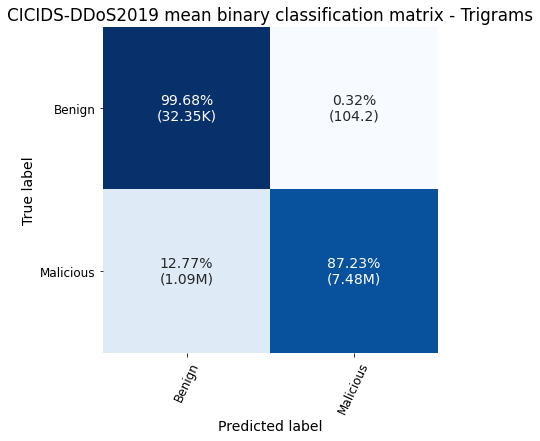

In [6]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#column_labels = sorted(df_test[label].unique())
#column_labels[6] = 'Benign'
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("CICIDS-DDoS2019 mean binary classification matrix - Trigrams")
#plt.savefig('ddos2019_binaryclass_cf_trigrams_reduced.png',bbox_inches='tight')
plt.show()

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

32350.8 104.2 1094785.2 7475340.8
Accuracy: 0.8727254762262628 

Recall: 0.8722556471165068 

Specificity: 0.9967894007086735
0.0032105992913264523


In [35]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: ngram_Bwd Packet Length Max_mean, Score: 0.17347
Feature: ngram_Total Backward Packets_std, Score: 0.11545
Feature: ngram_Bwd Packet Length Max_std, Score: 0.09821
Feature: ngram_Total Length of Bwd Packets_mean, Score: 0.08741
Feature: ngram_Fwd Packet Length Min_mean, Score: 0.07771
Feature: ngram_Bwd Packet Length Min_mean, Score: 0.06124
Feature: ngram_Total Length of Bwd Packets_std, Score: 0.05852
Feature: ngram_Total Length of Fwd Packets_mean, Score: 0.05624
Feature: ngram_Bwd Packet Length Min_std, Score: 0.04448
Feature: ngram_Total Fwd Packets_mean, Score: 0.03906
Feature: ngram_Fwd Packet Length Max_mean, Score: 0.02764
Feature: ngram_Flow Bytes/s_mean, Score: 0.02334
Feature: ngram_Total Backward Packets_mean, Score: 0.01281
Feature: ngram_Fwd Packet Length Min_std, Score: 0.01237
Feature: ngram_Flow Duration_std, Score: 0.01128
Feature: ngram_Total Length of Fwd Packets_std, Score: 0.01051
Feature: ngram_Fwd Packet Length Max_std, Score: 0.01011
Feature: ngram_Fl

## Alternative features results

In [23]:
np.set_printoptions(suppress=True)
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)
objectToFile(preds, "ddos2019_alternative_preds_reduced_"+label)

[array([[  31550,     905],
       [ 324435, 8245691]]), array([[  31544,     911],
       [ 321441, 8248685]]), array([[  31555,     900],
       [ 325328, 8244798]]), array([[  31515,     940],
       [ 322482, 8247644]]), array([[  31544,     911],
       [ 323829, 8246297]])]
(5, 2, 2)
[[  31541.6     913.4]
 [ 323503.  8246623. ]]
[[  13.92264343   13.92264343]
 [1385.62693392 1385.62693392]]
std. dev %
 [[0.04414057 1.52426576]
 [0.42831966 0.01680236]]


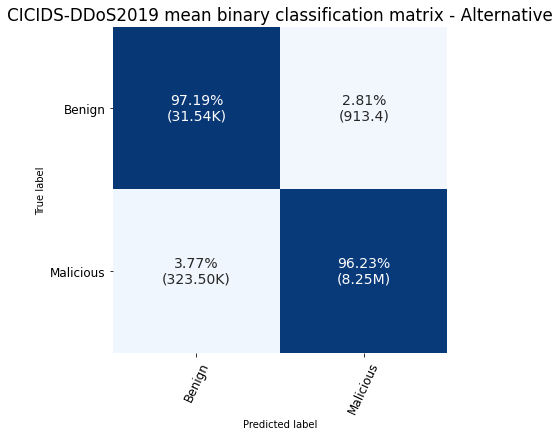

In [24]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
column_labels = sorted(df_test[label].unique())
#column_labels[6] = 'Benign'
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("CICIDS-DDoS2019 mean binary classification matrix - Alternative")
plt.savefig('ddos2019_binaryclass_cf_alternative_reduced.png',bbox_inches='tight')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

31541.6 913.4 323503.0 8246623.0
Accuracy: 0.9622884806315686 

Recall: 0.9622522469331256 

Specificity: 0.9718564165767986
0.028143583423201356


In [25]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: Bwd Packet Length Max, Score: 0.20926
Feature: Fwd Packet Length Min, Score: 0.15905
Feature: Total Length of Bwd Packets, Score: 0.15752
Feature: Total Length of Fwd Packets, Score: 0.11179
Feature: Bwd Packet Length Min, Score: 0.07860
Feature: Total Fwd Packets, Score: 0.07568
Feature: Fwd Packet Length Max, Score: 0.05490
Feature: Flow Bytes/s, Score: 0.03904
Feature: Flow Duration, Score: 0.02438
Feature: Total Backward Packets, Score: 0.02056
Feature: Flow IAT Max, Score: 0.01773
Feature: Flow IAT Std, Score: 0.01425
Feature: Flow IAT Mean, Score: 0.01309
Feature: Flow Packets/s, Score: 0.01269
Feature: Flow IAT Min, Score: 0.01146


## Barplot of own feature sets

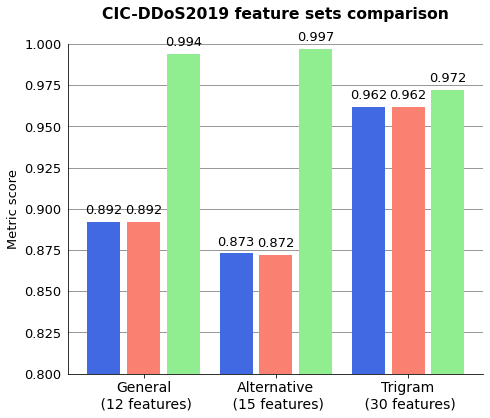

In [7]:
import matplotlib.patches as mpatches

#Scores
genset_acc = 0.892
genset_rec = 0.892
genset_spec = 0.994
trigramset_acc = 0.873
trigramset_rec = 0.872
trigramset_spec = 0.997
altset_acc = 0.962
altset_rec = 0.962
altset_spec = 0.972

#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['General\n (12 features)', 'Alternative\n (15 features)', \
          'Trigram\n (30 features)']

x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [genset_acc,genset_rec,genset_spec,trigramset_acc,trigramset_rec,trigramset_spec,altset_acc,altset_rec,altset_spec]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0], height=scores[1], width=width, color=clr_rec)
plt.bar(x[0]+pad_width, height=scores[2], width=width, color=clr_spec)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width, height=scores[3], width=width, color=clr_acc)
plt.bar(x[1], height=scores[4], width=width, color=clr_rec)
plt.bar(x[1]+pad_width, height=scores[5], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[6], width=width, color=clr_acc)
plt.bar(x[2], height=scores[7], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[8], width=width, color=clr_spec)

#Hide the left, right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
plt.ylabel('Metric score')
plt.yticks()
#ax.set_yticklabels([])
plt.ylim([0.8, 1])
#ax.get_yaxis().set_visible(False)
plt.xticks(size='14')
plt.title("CIC-DDoS2019 feature sets comparison", fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch], loc='lower right', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y', color='grey')
fig.tight_layout()
plt.savefig('ddos2019_binaryclass_reduced_featuresets_bars.png',bbox_inches='tight')
plt.show()